In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib widget
from ipywidgets import HBox, FloatSlider

In [2]:
df = pd.read_pickle('../bag_data/imu_bag_fixed.pickle')

In [3]:
df.shape

(288688, 71)

In [4]:
df_imu_linear = df[[ 'imu__linear_acceleration_y', 'imu__linear_acceleration_z']].dropna()
df_imu_linear['imu__linear_acceleration_y'] -= -1.568076
df_imu_linear['imu__linear_acceleration_z'] -= -0.005081
linear_g = np.sum(np.abs(df_imu_linear.values),axis=1)
linear_g.shape

(30286,)

In [5]:
df_imu_linear.describe()

,imu__linear_acceleration_y,imu__linear_acceleration_z
count,3.028600e+04,3.028600e+04
mean,2.070798e-07,-3.935732e-07
std,1.978042e-01,2.756683e-01
min,-5.092438e+00,-3.342362e+00
25%,-6.422080e-02,-6.991078e-02
50%,-8.455053e-03,-1.059144e-02
75%,6.589936e-02,6.850107e-02
max,3.021487e+00,4.675637e+00


In [6]:
df_g = pd.Series(linear_g)
df_g.describe()


count    30286.000000
mean         0.241906
std          0.347839
min          0.001544
25%          0.086476
50%          0.143793
75%          0.251361
max          6.395922
dtype: float64

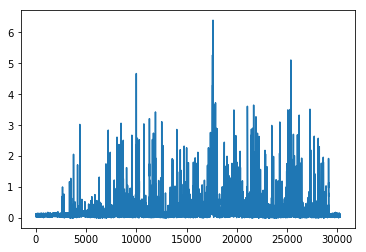

In [7]:
plt.plot(linear_g)
plt.show()

In [11]:
imu_ang_vel_x = df.imu__angular_velocity_x.values
imu_linear_vel_y = df.imu__linear_acceleration_y.values
imu_linear_vel_z = df.imu__linear_acceleration_z.values
encoder_ang_vel_z = df.vel__twist_angular_z.values
ground_pose_theta = df.robot_markerset_ground_pose__theta.values

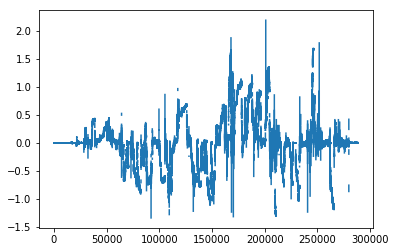

In [20]:
plt.plot(df.vel__twist_angular_z.values)
plt.show()

In [12]:
def calc(gain_imu):
    ground_last_theta = 0
    last_encoder_ang_vel_z = 0
    g_th_max = 10.0
    g_th_min =  0.143793
    imu_angular_bias = -0.345464
    fake_ground_pose_theta = 0.495

    #gain_angular = 0.99987
    dt = 0.01
    calculated_thetas = []
    ground_thetas = []
    for i in range(df.shape[0]):
        if not np.isnan(ground_pose_theta[i]):
            if not np.isclose(ground_pose_theta[i] , fake_ground_pose_theta, atol=0.005):
                ground_last_theta = ground_pose_theta[i]
                #print(ground_last_theta)
        if not np.isnan(encoder_ang_vel_z[i]):
            last_encoder_ang_vel_z = encoder_ang_vel_z[i]
        if not np.isnan(imu_ang_vel_x[i]):
            ground_thetas.append(ground_last_theta)
            new_theta = (imu_ang_vel_x[i] - imu_angular_bias)* dt
            new_theta = gain_imu * new_theta + (1.0-gain_imu) * last_encoder_ang_vel_z
                #print( theta_acc)
            calculated_thetas.append(-new_theta)
    calculated_thetas_cumsum = np.cumsum(calculated_thetas)
    return np.unwrap(ground_thetas),calculated_thetas_cumsum

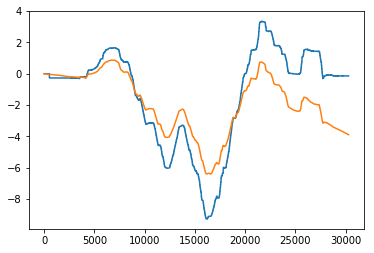

In [19]:
fig = plt.figure()
ground,computed = calc(0.9983)
plt.plot(ground)
plt.plot(computed)
plt.show()

    

In [ ]:
df[df.vel__twist_linear_x.notnull()].sample(20)

In [ ]:
from scipy.spatial import distance
from datetime import date

vel_linear_x = df.vel__twist_linear_x.values
ground_pose_x = df.robot_markerset_ground_pose__x.values
ground_pose_y = df.robot_markerset_ground_pose__y.values
prev_x = 0
prev_y = 0
enc_dt_min = 0.01
p2p_ground_euc_distances = []
linear_euc_distances = []
prev_encoder_time = 0
print(df.index[10])
for i in range(df.shape[0]):
    if not np.isnan(vel_linear_x[i]) and df.index[i] > pd.Timestamp(1971, 1, 1, 12):
        if prev_encoder_time == 0:
            prev_encoder_time = df.index[i]
        current_dt = (df.index[i]- prev_encoder_time).total_seconds()
        #print(current_dt)
        if current_dt >= enc_dt_min:
            linear_euc_distances.append(abs(vel_linear_x[i]) * current_dt)
            prev_encoder_dt = df.index[i]
    if not np.isnan(ground_pose_x[i]) and not np.isnan(ground_pose_y[i]):
        p2p_ground_euc_distances.append(distance.euclidean((ground_pose_x[i],ground_pose_y[i]), (prev_x,prev_y)))
        prev_x = ground_pose_x[i]
        prev_y = ground_pose_y[i]



In [ ]:
linear_euc_distances[:10]

In [ ]:
p2p_ground_euc_distances[:10]

In [ ]:
fig = plt.figure()
plt.plot(np.cumsum(p2p_ground_euc_distances))
plt.plot(np.cumsum(linear_euc_distances))
plt.show()